# `UrysohnClassifier` Numerical Experiments

## Loading useful libraries

In [1]:
from source.config import get_config
from source.libraries import *
from source.data_preprocessing import *
from source.ml_toolbox import *
from source.metrics import *

config = get_config("numerical_experiments")

## Computational efficiency analysis

### Inference time scaling with dataset size and dimensionality

In [43]:
# Parameter grid
sample_range = np.linspace(100, 10000, 10, dtype=int)
feature_range = np.linspace(5, 200, 10, dtype=int)

def inference_time(sample_range,feature_range, p):
    # Grid to store inference time values
    inference_time_grid = np.zeros((len(sample_range), len(feature_range)))
    # Evaluate inference time over grid
    for i, n_samples in enumerate(sample_range):
        for j, n_features in enumerate(feature_range):
            # Generate synthetic dataset
            X, y = make_classification(n_samples=n_samples,
                                       n_features=n_features,
                                       n_informative=int(n_features * 0.6),
                                       n_redundant=int(n_features * 0.2),
                                       n_classes=2,
                                       random_state=config.SEED)
            # Train/test split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                                random_state=config.SEED,
                                                                stratify=y)
            # Train classifier
            clf = UrysohnClassifier(p=1, threshold=0.5, n_jobs=-1)
            clf.fit(X_train, y_train)
            # Measure inference time
            start_time = time.time()
            _ = clf.predict_proba(X_test)  # or clf.predict(X_test) if appropriate
            elapsed_time = time.time() - start_time
            # Store time in seconds
            inference_time_grid[i, j] = elapsed_time
    return inference_time_grid


def plot_inference_time(feature_range, sample_range, p, fig_name):
    inference_time_grid = inference_time(sample_range,feature_range, p)
    # Meshgrid for plotting
    X_mesh, Y_mesh = np.meshgrid(feature_range, sample_range)
    # Plotting
    plt.figure(figsize=(10, 8))
    contourf = plt.contourf(X_mesh, Y_mesh, inference_time_grid, cmap='plasma', levels=20)
    plt.colorbar(contourf, label='Inference Time (seconds)')
    # Overlay contour lines for selected time levels
    time_levels = [1, 2, 4, 6, 8, 10]
    contours = plt.contour(X_mesh, Y_mesh, inference_time_grid, 
                           levels=time_levels, 
                           colors='black',
                           linestyles='solid')
    plt.clabel(contours, inline=True, fontsize=16, fmt='%.2f')
    # Labels and layout
    plt.xlabel('Number of features',fontsize=16)
    plt.ylabel('Number of samples',fontsize=16)
    # plt.legend('p=1')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    # Save figure
    plt.savefig(config.FIGS/str(fig_name), dpi=700,bbox_inches='tight')
    plt.show()

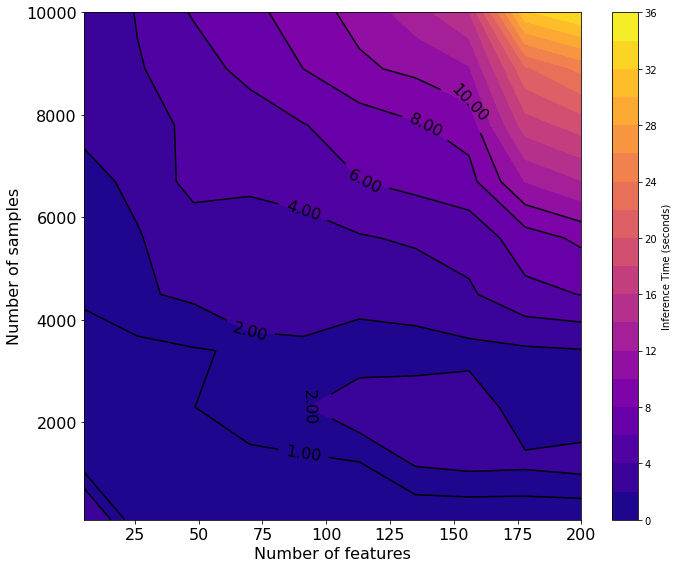

In [44]:
plot_inference_time(feature_range, sample_range, 1, 'Fig_06.pdf')

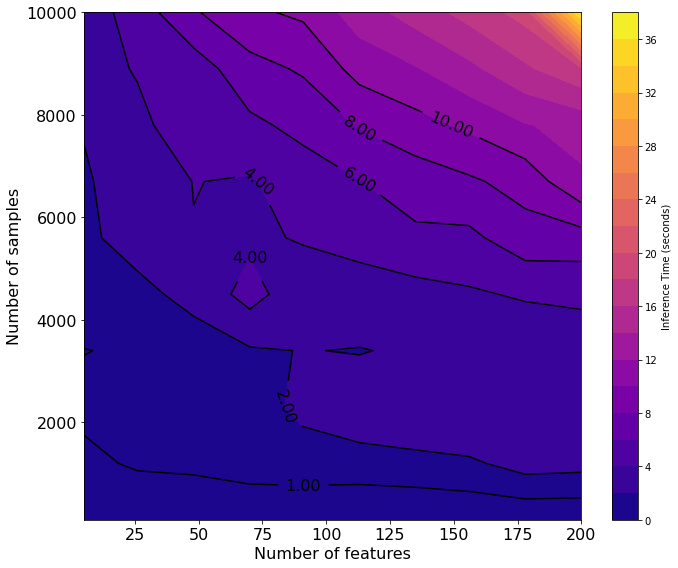

In [45]:
plot_inference_time(feature_range, sample_range, 2, 'Fig_07.pdf')

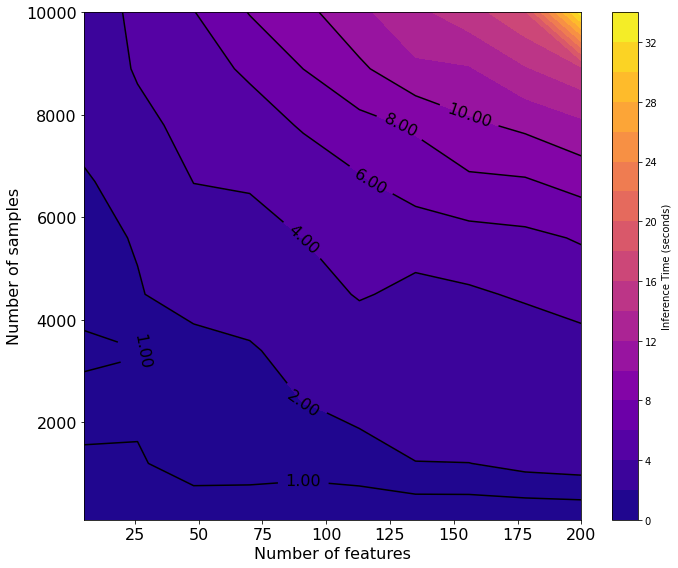

In [46]:
plot_inference_time(feature_range, sample_range, 3, 'Fig_08.pdf')

### Curse of dimensionality

Processing m = 5
Processing m = 10
Processing m = 15
Processing m = 20
Processing m = 25
Processing m = 30
Processing m = 35
Processing m = 40
Processing m = 45


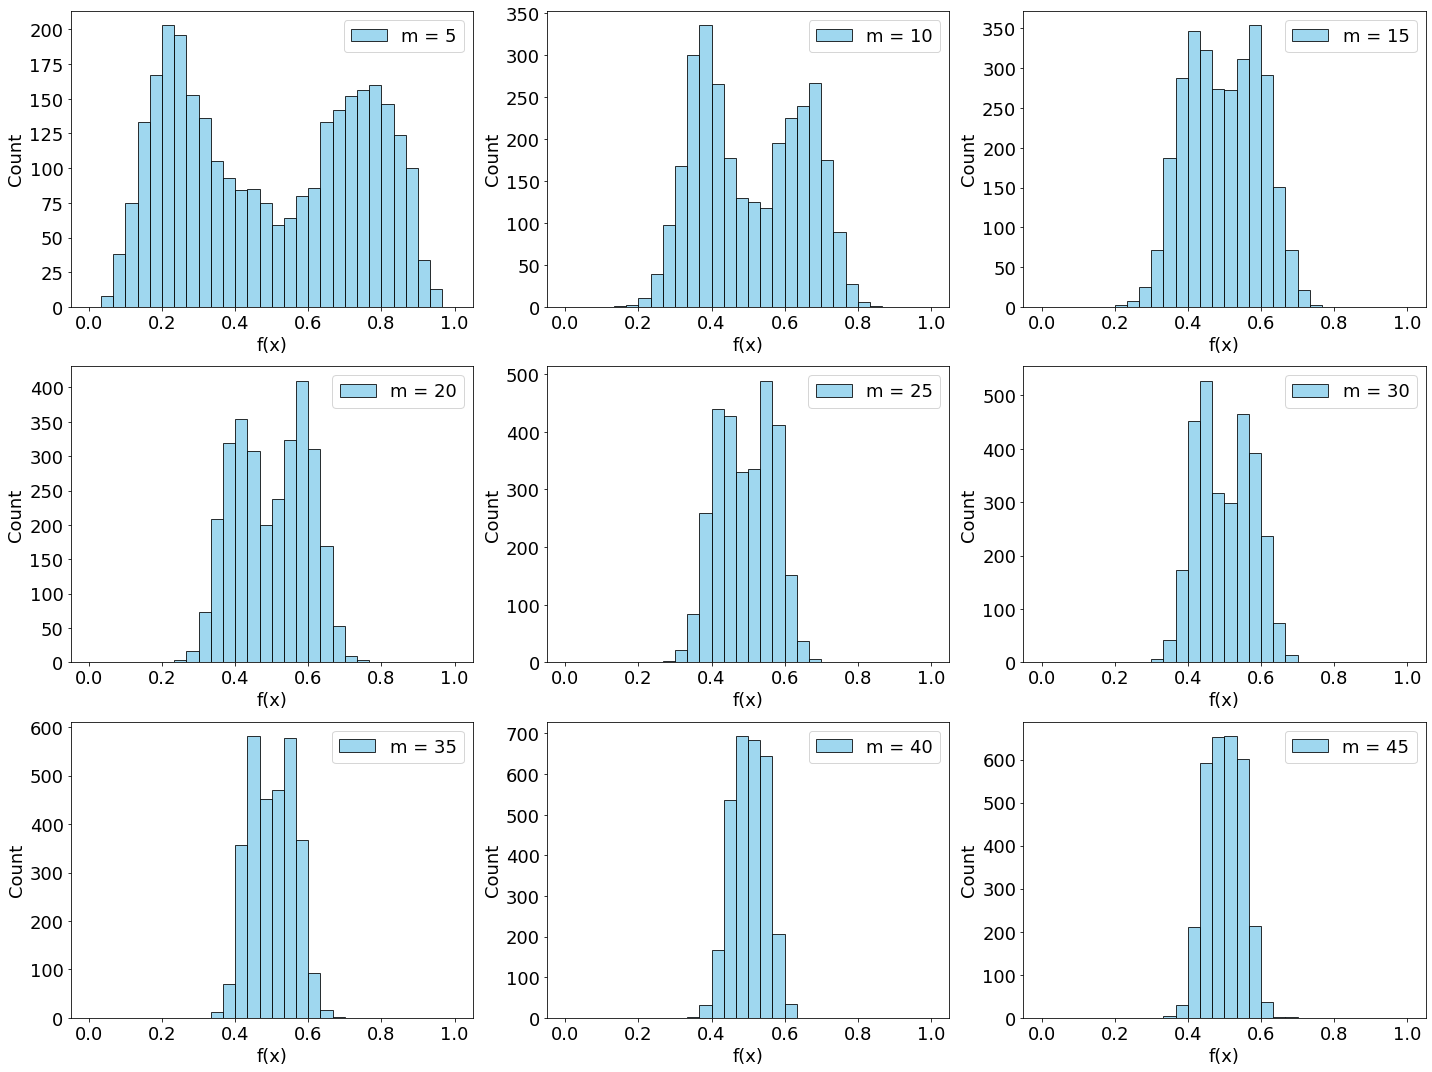

In [3]:
# Parameters
dimensions = list(range(5, 46, 5))  # Dimensionality range
n_samples = 10000
p = 1  # Manhattan distance

# Store results
fx_distributions = []

# Loop over dimensions
for d in dimensions:
    print(f"Processing m = {d}")
    
    # Generate synthetic dataset
    X, y = make_classification(n_samples=n_samples,
                               n_features=d,
                               n_informative=int(0.6 * d),
                               n_redundant=int(0.2 * d),
                               n_classes=2,
                               random_state=config.SEED)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=config.SEED)

    # Train UrysohnClassifier
    clf = UrysohnClassifier(p=p, threshold=0.5, n_jobs=-1)
    clf.fit(X_train, y_train)

    # Compute predicted scores
    fx_scores = clf.predict_proba(X_test)[:, 1]
    fx_distributions.append(fx_scores)

# Plot results
n_cols = 3
n_rows = len(dimensions) // n_cols + (len(dimensions) % n_cols > 0)
plt.figure(figsize=(20, 15))

for i, (d, fx) in enumerate(zip(dimensions, fx_distributions)):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.hist(fx, bins=30, range=(0, 1), color='skyblue', edgecolor='black', alpha=0.8, label=f'm = {d}')
    plt.legend(loc='best',fontsize=18)
    plt.xlabel('f(x)',fontsize=18)
    plt.ylabel('Count',fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()

plt.savefig(config.FIGS/'Fig_09.pdf', dpi=700,bbox_inches='tight')
plt.show()

### Computational Efficiency Trade-Offs

Evaluating p=1...
Evaluating p=2...
Evaluating p=3...
Evaluating p=4...
Evaluating p=5...
Evaluating p=6...
Evaluating p=7...
Evaluating p=8...
Evaluating p=9...


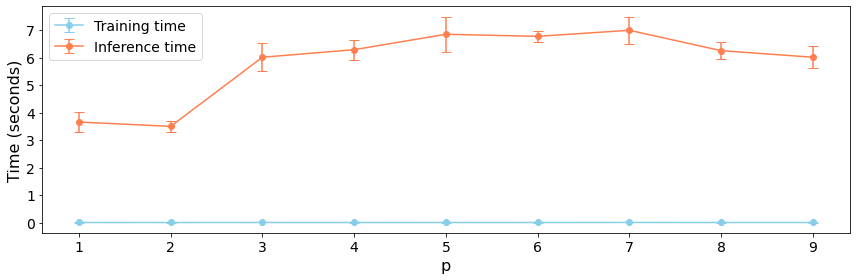

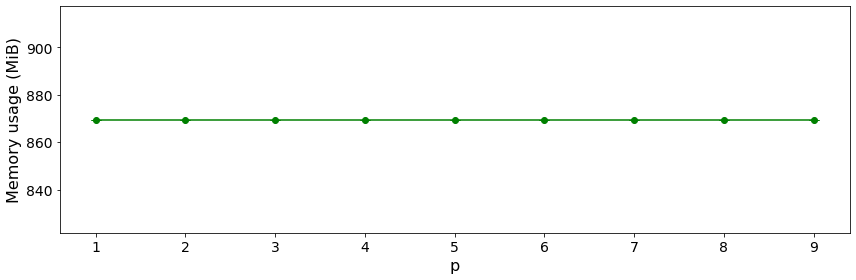

In [56]:
# Settings
p_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]
n_samples, n_features = 10000, 15
num_repeats = 5  # Number of runs to estimate standard deviation

# Storage
training_times, inference_times, memory_usages = [], [], []

# Dataset
X, y = make_classification(n_samples=n_samples,
                           n_features=n_features,
                           n_informative=int(n_features * 0.6),
                           n_redundant=int(n_features * 0.2),
                           n_classes=2,
                           random_state=config.SEED)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=config.SEED)

# Benchmark loop
for p in p_values:
    print(f"Evaluating p={p}...")
    train_times_p, infer_times_p, mem_usages_p = [], [], []

    for _ in range(num_repeats):
        def train_and_measure():
            clf = UrysohnClassifier(p=p, threshold=0.5, n_jobs=-1)
            t0 = time.time()
            clf.fit(X_train, y_train)
            t1 = time.time()
            train_time = t1 - t0
            t2 = time.time()
            _ = clf.predict_proba(X_test)
            t3 = time.time()
            infer_time = t3 - t2
            return train_time, infer_time

        mem_usage, (train_time, infer_time) = memory_usage(
            (train_and_measure,), retval=True, max_usage=True, interval=0.05
        )

        train_times_p.append(train_time)
        infer_times_p.append(infer_time)
        mem_usages_p.append(mem_usage)

    training_times.append((np.mean(train_times_p), np.std(train_times_p)))
    inference_times.append((np.mean(infer_times_p), np.std(infer_times_p)))
    memory_usages.append((np.mean(mem_usages_p), np.std(mem_usages_p)))

# Unpack results
train_means, train_stds = zip(*training_times)
infer_means, infer_stds = zip(*inference_times)
mem_means, mem_stds = zip(*memory_usages)

# Plot times
plt.figure(figsize=(12, 4))
plt.errorbar(p_values, train_means, yerr=train_stds, label='Training time', color='skyblue', marker='o', capsize=5)
plt.errorbar(p_values, infer_means, yerr=infer_stds, label='Inference time', color='coral', marker='o', capsize=5)
plt.xlabel('p', fontsize=16)
plt.ylabel('Time (seconds)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig(config.FIGS/'Fig_10.pdf', dpi=700, bbox_inches='tight')
plt.show()

# Plot memory usage
plt.figure(figsize=(12, 4))
plt.errorbar(p_values, mem_means, yerr=mem_stds, color='green', marker='o', capsize=5)
plt.xlabel('p', fontsize=16)
plt.ylabel('Memory usage (MiB)', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig(config.FIGS/'Fig_11.pdf', dpi=700, bbox_inches='tight')
plt.show()


In [57]:
train_means, train_stds = zip(*training_times)
infer_means, infer_stds = zip(*inference_times)
mem_means, mem_stds = zip(*memory_usages)

In [58]:
print("Average training times: {}".format(np.mean(train_means)))
print(" ")
print("Minimum inference times: {}".format(min(infer_means)))
print("Maximum inference times: {}".format(max(infer_means)))
print(" ")
print("Average memory use: {}".format(np.mean(mem_means)))
print(" ")
print("Min memory use: {}".format(min(mem_means)))
print("Max memory use: {}".format(max(mem_means)))

Average training times: 0.0032813337114122178
 
Minimum inference times: 3.4970703125
Maximum inference times: 6.990149021148682
 
Average memory use: 869.53125
 
Min memory use: 869.53125
Max memory use: 869.53125


## Performance evaluation

### Scaling performance with dataset size and dimensionality

In [52]:
# Define parameter grid
sample_range, feature_range = np.linspace(100, 10000, 10, dtype=int), np.linspace(5, 200, 10, dtype=int)
roc_auc_grid = np.zeros((len(sample_range), len(feature_range)))


def grid_evaluation(sample_range, feature_range, p):
    for i, n_samples in enumerate(sample_range):
        for j, n_features in enumerate(feature_range):
            # Generate synthetic dataset
            X, y = make_classification(n_samples=n_samples,
                                       n_features=n_features,
                                       n_informative=int(n_features * 0.6),
                                       n_redundant=int(n_features * 0.2),
                                       n_classes=2,
                                       random_state=config.SEED)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=config.SEED, stratify=y)
            clf = UrysohnClassifier(p=p, threshold=0.5, n_jobs=-1)
            clf.fit(X_train, y_train)
            y_proba = clf.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_proba)
            roc_auc_grid[i, j] = auc
    return roc_auc_grid

def plot_performance_auc(feature_range, sample_range, p, fig_name):
    roc_auc_grid = grid_evaluation(sample_range, feature_range, p)
    # Plot contour with filled surface
    X_mesh, Y_mesh = np.meshgrid(feature_range, sample_range)
    plt.figure(figsize=(10, 8))
    contourf = plt.contourf(X_mesh, Y_mesh, roc_auc_grid, cmap='viridis', levels=20)
    plt.colorbar(contourf, label='ROC-AUC')

    # Overlay specific contour lines
    contour_lines = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.98]
    contours = plt.contour(X_mesh, Y_mesh, roc_auc_grid, levels=contour_lines, colors='black', linestyles='solid')
    plt.clabel(contours, inline=True, fontsize=16, fmt='%.2f')

    # Labels and layout
    plt.xlabel('Number of features',fontsize=16)
    plt.ylabel('Number of samples',fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()

    # Save figure to file
    plt.savefig(config.FIGS/str(fig_name), dpi=700,bbox_inches='tight')
    plt.show()

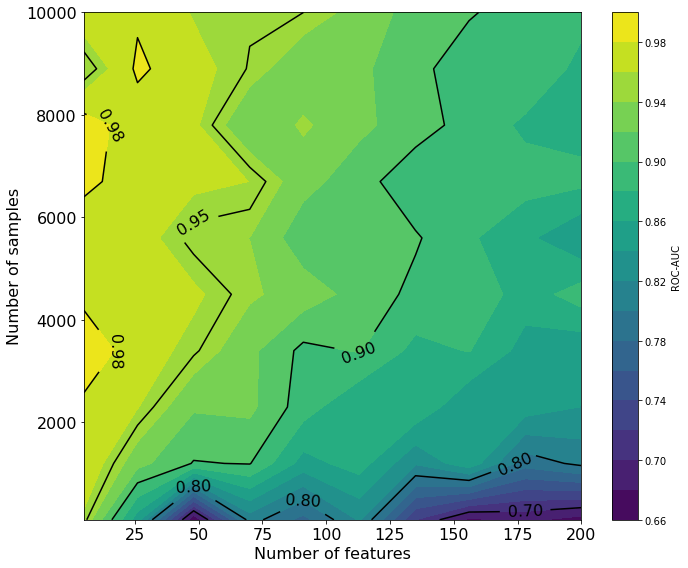

In [53]:
plot_performance_auc(feature_range, sample_range, 1, 'Fig_12.pdf')

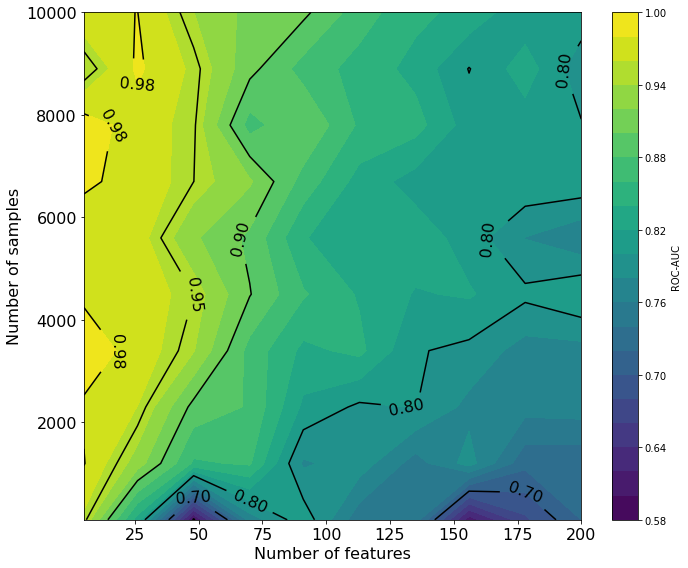

In [54]:
plot_performance_auc(feature_range, sample_range, 2, 'Fig_13.pdf')

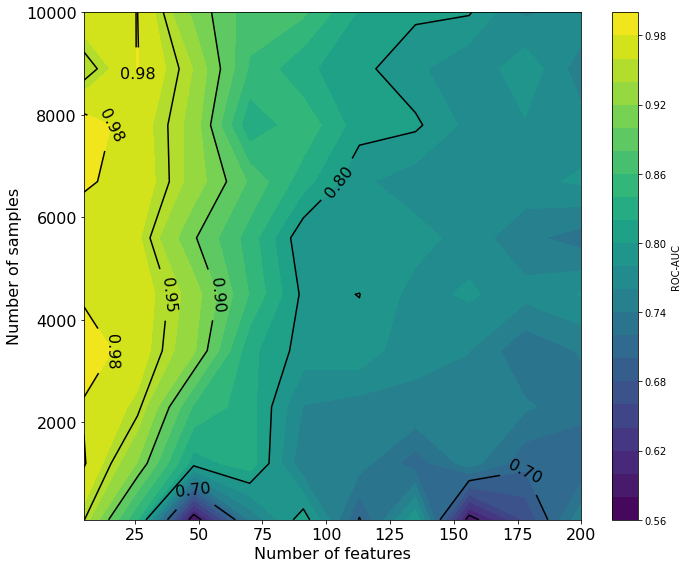

In [55]:
plot_performance_auc(feature_range, sample_range, 3, 'Fig_14.pdf')

### Sensitivity to hyperparameters

In [59]:
# Generate synthetic dataset
n_samples, n_features = 10000, 15
X, y = make_classification(n_samples=n_samples,
                           n_features=n_features,
                           n_informative=int(n_features * 0.6),
                           n_redundant=int(n_features * 0.2),
                           n_classes=2,
                           random_state=config.SEED)

# Step 2: Performance analysis for contour plot
def performance_analysis(X, y, p_range, threshold_range, calibration):
    results = []

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=config.SEED)
    for p in p_range:
        for threshold in threshold_range:
            clf = UrysohnClassifier(p=p, threshold=threshold, n_jobs=-1)

            if calibration == 'sigmoid':
                clf = CalibratedClassifierCV(clf, method='sigmoid')
            elif calibration == 'isotonic':
                clf = CalibratedClassifierCV(clf, method='isotonic')

            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            f1 = f1_score(y_test, y_pred)
            results.append({'p': p, 'threshold': threshold, 'f1': f1})

    return pd.DataFrame(results)

# Step 3: Contour plot
def plot_baccuracy_contour(df, fig_name):
    pivot = df.pivot(index='threshold', columns='p', values='f1')
    p_vals = pivot.columns.values
    threshold_vals = pivot.index.values
    f1 = pivot.values

    plt.figure(figsize=(10, 6))
    contour_lines = [0.0, 0.4, 0.8, 1.0]
    cp = plt.contourf(p_vals, threshold_vals, f1, levels=contour_lines, cmap='viridis')
    contour = plt.contour(p_vals, threshold_vals, f1, levels=contour_lines, colors='black', linewidths=0.5)
    plt.clabel(contour, inline=True, fontsize=16, fmt='%.2f')

    cbar = plt.colorbar(cp)
    cbar.set_label('F1 score')

    plt.xlabel('p', fontsize=16)
    plt.ylabel('Threshold', fontsize=16)
    plt.xticks(p_vals, fontsize=16)
    plt.yticks([0.0,0.25,0.45,0.5,0.55,0.75,1.0], fontsize=16)
    plt.tight_layout()
    plt.savefig(config.FIGS / str(fig_name), dpi=700)
    plt.show()

# Step 4: Run the experiment
p_range = [1, 2, 3, 4, 5, 6, 7, 8, 9]
threshold_range = np.linspace(0.0, 1.0, 10)

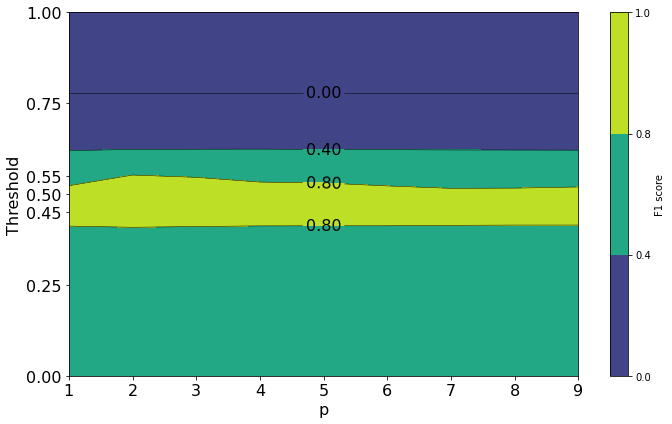

In [60]:
df_results = performance_analysis(X, y, p_range, threshold_range, calibration=None)
plot_baccuracy_contour(df_results, 'Fig_15.pdf')

### Discriminatory power and calibration metrics

In [49]:
# Generate synthetic dataset
n_samples, n_features =10000, 15
X, y = make_classification(n_samples=n_samples,
                           n_features=n_features,
                           n_informative=int(n_features * 0.6),
                           n_redundant=int(n_features * 0.2),
                           n_classes=2,
                           random_state=config.SEED)
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=config.SEED)

In [50]:
ury = UrysohnClassifier(p = 1, threshold = 0.5, n_jobs = -1)
ury.fit(X_train,y_train)

UrysohnClassifier(n_jobs=-1, p=1)

In [51]:
discriminatory_power = evaluate_model_metrics(ury, X_test, y_test, n_iter=100, 
                                              sample_size=100, compute_psi=False)
discriminatory_power.describe()

Evaluating model: 100%|██████████| 100/100 [03:29<00:00,  2.10s/it]


,Accuracy,ROC-AUC,Precision,Recall,F1 Score,Gini Index,Kolmogorov Smirnov,Brier Score,Logloss Score,Cohen Kappa,Calibration Error
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
mean,0.909700,0.967148,0.917759,0.901600,0.908873,0.934296,0.84980,0.180255,0.550798,0.819400,0.321128
std,0.027357,0.015018,0.036143,0.039663,0.027829,0.030036,0.04658,0.004494,0.009275,0.054714,0.018341
min,0.830000,0.917600,0.823529,0.800000,0.831683,0.835200,0.70000,0.168284,0.525642,0.660000,0.268633
25%,0.890000,0.959800,0.890909,0.880000,0.893204,0.919600,0.82000,0.177197,0.544636,0.780000,0.311631
50%,0.910000,0.967000,0.918367,0.900000,0.909091,0.934000,0.86000,0.181008,0.552477,0.820000,0.321213
75%,0.930000,0.977700,0.940000,0.925000,0.927835,0.955400,0.88000,0.183767,0.557888,0.860000,0.332397
max,0.970000,0.995600,0.979592,0.980000,0.969697,0.991200,0.96000,0.189966,0.570983,0.940000,0.380434


In [52]:
# Aggregate metrics
confusion_matrices, roc_curves, calibration_curves = aggregate_confusion_matrix_roc_calibration(ury, X_test,
                                                                                                y_test,
                                                                                                batch_size=100,
                                                                                                n_iterations=100)

100%|██████████| 100/100 [03:13<00:00,  1.93s/it]


#### Discriminatory

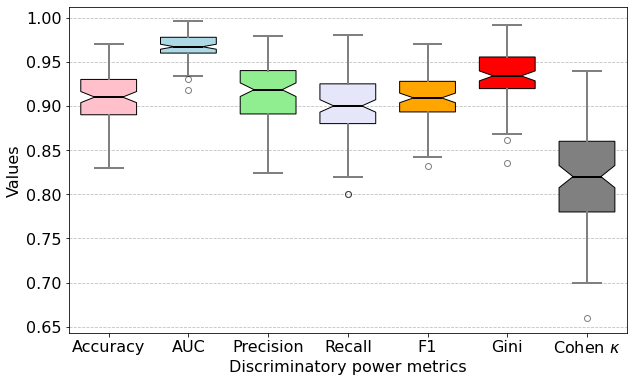

In [53]:
# Combine data into a single list
ury_metrics = discriminatory_power[['Accuracy','ROC-AUC','Precision','Recall','F1 Score', 'Gini Index', 'Cohen Kappa']]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a box plot
box = ax.boxplot(ury_metrics, patch_artist=True, notch=True, vert=True, widths=0.7)

# Customize box plot
colors = ['pink', 'lightblue', 'lightgreen', 'lavender', 'orange', 'red', 'gray']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Customize other box plot elements
plt.setp(box['whiskers'], color='gray', linewidth=2)
plt.setp(box['caps'], color='gray', linewidth=2)
plt.setp(box['medians'], color='black', linewidth=2)
plt.setp(box['fliers'], marker='o', color='red', alpha=0.5)

# Add title and labels
# ax.set_title('Fancy Box Plot for Five Lists', fontsize=16)
ax.set_xlabel('Discriminatory power metrics', fontsize=16)
ax.set_ylabel('Values', fontsize=16)

# Add grid
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Set x-tick labels
ax.set_xticklabels(['Accuracy','AUC','Precision','Recall','F1', 'Gini', 'Cohen $\kappa$'],
                   fontsize=16,rotation=0)
# Set y-tick labels
plt.yticks(fontsize=16)

plt.savefig(config.FIGS/'Fig_16.pdf', dpi=700, bbox_inches='tight')

# Show plot
plt.show()

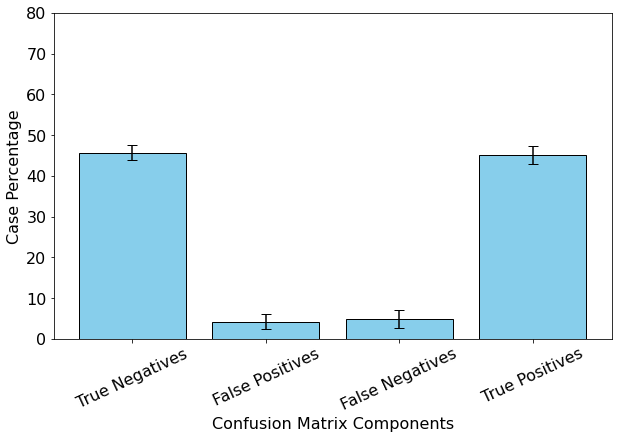

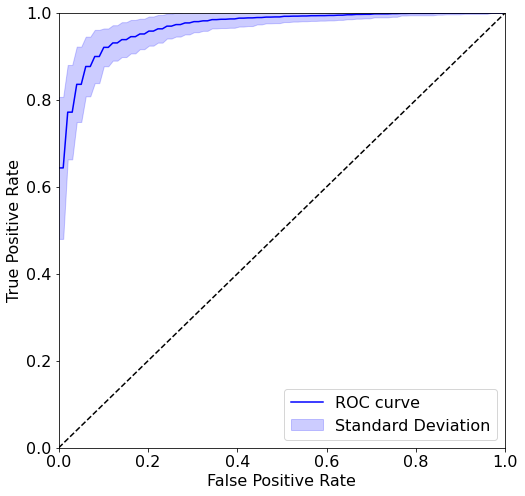

In [54]:
# Convert lists to numpy arrays for easy calculation
confusion_matrices = np.array(confusion_matrices)
roc_curves = np.array(roc_curves, dtype=object)

# Calculate mean and std for confusion matrix components
confusion_means = confusion_matrices.mean(axis=0)
confusion_stds = confusion_matrices.std(axis=0)

# Plot confusion matrix histogram with error bars
labels = ['True Negatives', 'False Positives', 'False Negatives', 'True Positives']
x = np.arange(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, confusion_means, yerr=confusion_stds, capsize=5, color='skyblue', edgecolor='black')
plt.xticks(x, labels,rotation=25,fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Case Percentage',fontsize=16)
plt.xlabel('Confusion Matrix Components',fontsize=16)
plt.ylim(0,80)
plt.grid(False)
plt.savefig(config.FIGS/'Fig_17.pdf', dpi=700, bbox_inches='tight')
plt.show()

# Calculate mean and std for ROC curve
fpr_values = np.linspace(0, 1, 100)
tpr_interp = np.array([np.interp(fpr_values, fpr, tpr) for fpr, tpr in roc_curves])
tpr_mean = tpr_interp.mean(axis=0)
tpr_std = tpr_interp.std(axis=0)

# Plot ROC curve with shaded areas
plt.figure(figsize=(8, 8))
plt.plot(fpr_values, tpr_mean, color='b', label='ROC curve')
plt.fill_between(fpr_values, tpr_mean - tpr_std, tpr_mean + tpr_std, color='blue', alpha=0.2, label='Standard Deviation')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('ROC Curve with Standard Deviation')
plt.legend(loc='lower right',fontsize=16)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(False)
plt.savefig(config.FIGS/'Fig_18.pdf', dpi=700, bbox_inches='tight')
plt.show()

In [55]:
print('Average True Negatives: {[0]}'.format(confusion_means))
print('Average False Positives: {[1]}'.format(confusion_means))
print('Average False Negatives: {[2]}'.format(confusion_means))
print('Average True Positives: {[3]}'.format(confusion_means))
print('Standard Deviation confusion matrix {}'.format(confusion_stds))

Average True Negatives: 45.74
Average False Positives: 4.26
Average False Negatives: 4.9
Average True Positives: 45.1
Standard Deviation confusion matrix [1.85267374 1.85267374 2.12367606 2.12367606]


#### Calibration

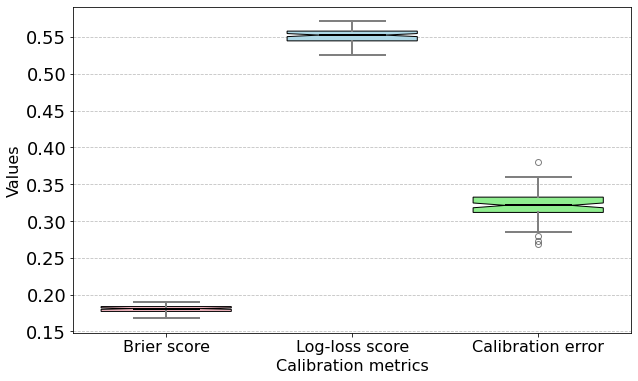

In [56]:
# Combine data into a single list
ury_metrics = discriminatory_power[['Brier Score', 'Logloss Score', 'Calibration Error']]

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Create a box plot
box = ax.boxplot(ury_metrics, patch_artist=True, notch=True, vert=True, widths=0.7)

# Customize box plot
colors = ['pink', 'lightblue', 'lightgreen', 'lavender', 'orange']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Customize other box plot elements
plt.setp(box['whiskers'], color='gray', linewidth=2)
plt.setp(box['caps'], color='gray', linewidth=2)
plt.setp(box['medians'], color='black', linewidth=2)
plt.setp(box['fliers'], marker='o', color='red', alpha=0.5)


# Add title and labels
ax.set_xlabel('Calibration metrics', fontsize=16)
ax.set_ylabel('Values', fontsize=16)

# Add grid
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Set x-tick labels
ax.set_xticklabels(['Brier score', 'Log-loss score', 'Calibration error'],
                   fontsize=16,rotation=0)
# Set y-tick labels
plt.yticks(fontsize=18)

plt.savefig(config.FIGS/'Fig_19.pdf', dpi=700, bbox_inches='tight')


# Show plot
plt.show()

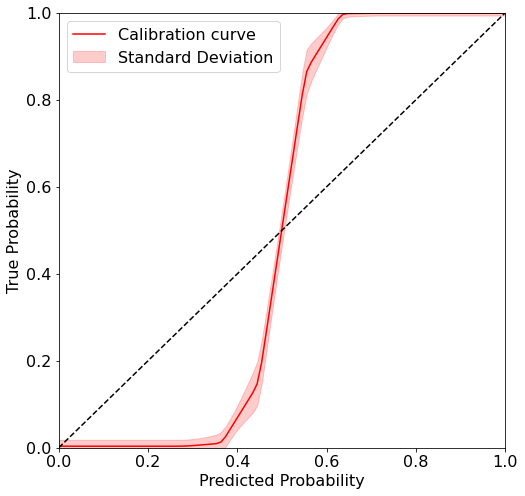

In [57]:
# Convert lists to numpy arrays for easy calculation
calibration_curves = np.array(calibration_curves, dtype=object)


# Calculate mean and std for Calibration curve
prob_true_interp = np.array([np.interp(fpr_values, prob_pred, prob_true) for prob_true, prob_pred in calibration_curves])
prob_true_mean = prob_true_interp.mean(axis=0)
prob_true_std = prob_true_interp.std(axis=0)

# Plot Calibration curve with shaded areas
plt.figure(figsize=(8, 8))
plt.plot(fpr_values, prob_true_mean, color='r', label='Calibration curve')
plt.fill_between(fpr_values, prob_true_mean - prob_true_std, prob_true_mean + prob_true_std, color='red', alpha=0.2, label='Standard Deviation')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Predicted Probability',fontsize=16)
plt.ylabel('True Probability',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('Calibration Curve with Standard Deviation')
plt.legend(loc='upper left',fontsize=16)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(False)
plt.savefig(config.FIGS/'Fig_20.pdf', dpi=700, bbox_inches='tight')
plt.show()

#### Sigmoid calibration

In [58]:
clf = CalibratedClassifierCV(ury, method='sigmoid')
clf.fit(X_train, y_train)

# Aggregate metrics
confusion_matrices, roc_curves, calibration_curves = aggregate_confusion_matrix_roc_calibration(clf, X_test,
                                                                                                y_test,
                                                                                                batch_size=100,
                                                                                                n_iterations=100)

100%|██████████| 100/100 [11:39<00:00,  7.00s/it]


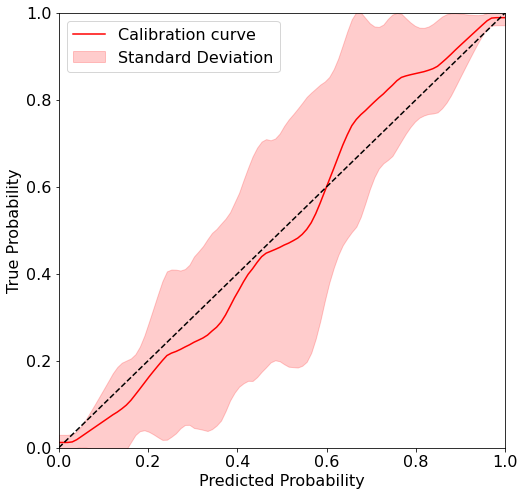

In [59]:
# Calculate mean and std for Calibration curve
calibration_curves = np.array(calibration_curves, dtype=object)
prob_true_interp = np.array([np.interp(fpr_values, prob_pred, prob_true) for prob_true, prob_pred in calibration_curves])
prob_true_mean = prob_true_interp.mean(axis=0)
prob_true_std = prob_true_interp.std(axis=0)


# Plot Calibration curve with shaded areas
plt.figure(figsize=(8, 8))
plt.plot(fpr_values, prob_true_mean, color='r', label='Calibration curve')
plt.fill_between(fpr_values, prob_true_mean - prob_true_std, prob_true_mean + prob_true_std, color='red', alpha=0.2, label='Standard Deviation')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Predicted Probability',fontsize=16)
plt.ylabel('True Probability',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('Calibration Curve with Standard Deviation')
plt.legend(loc='upper left',fontsize=16)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(False)
plt.savefig(config.FIGS/'Fig_21.pdf', dpi=700, bbox_inches='tight')
plt.show()

#### Isotonic calibration

In [60]:
clf = CalibratedClassifierCV(ury, method='isotonic')
clf.fit(X_train, y_train)

# Aggregate metrics
confusion_matrices, roc_curves, calibration_curves = aggregate_confusion_matrix_roc_calibration(clf, X_test,
                                                                                                y_test,
                                                                                                batch_size=100,
                                                                                                n_iterations=100)

100%|██████████| 100/100 [11:37<00:00,  6.97s/it]


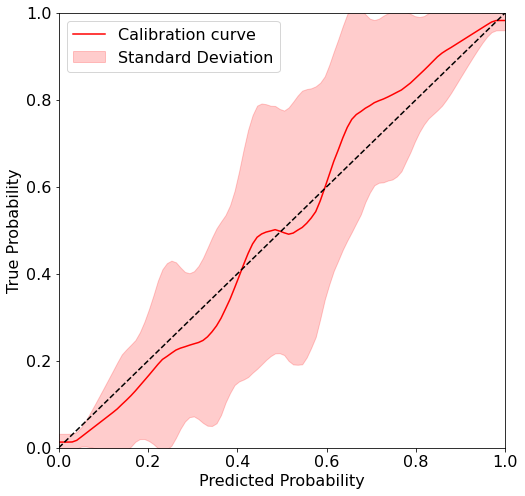

In [61]:
# Calculate mean and std for Calibration curve
calibration_curves = np.array(calibration_curves, dtype=object)
prob_true_interp = np.array([np.interp(fpr_values, prob_pred, prob_true) for prob_true, prob_pred in calibration_curves])
prob_true_mean = prob_true_interp.mean(axis=0)
prob_true_std = prob_true_interp.std(axis=0)


# Plot Calibration curve with shaded areas
plt.figure(figsize=(8, 8))
plt.plot(fpr_values, prob_true_mean, color='r', label='Calibration curve')
plt.fill_between(fpr_values, prob_true_mean - prob_true_std, prob_true_mean + prob_true_std, color='red', alpha=0.2, label='Standard Deviation')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Predicted Probability',fontsize=16)
plt.ylabel('True Probability',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('Calibration Curve with Standard Deviation')
plt.legend(loc='upper left',fontsize=16)
plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(False)
plt.savefig(config.FIGS/'Fig_22.pdf', dpi=700, bbox_inches='tight')
plt.show()

# Sensitivity analysis

## Sensitivity to the metric type

In [2]:
# Generate synthetic dataset
n_samples, n_features =10000, 15
X, y = make_classification(n_samples=n_samples,
                           n_features=n_features,
                           n_informative=int(n_features * 0.6),
                           n_redundant=int(n_features * 0.2),
                           n_classes=2,
                           random_state=config.SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=config.SEED)

ury_auc_tests = []
one_knn_auc_tests, three_knn_auc_tests, five_knn_auc_tests, seven_knn_auc_tests = [], [], [], []

p_metric = range(1, 10)  # Start from 1, as p=0 can cause issues in distance metrics
for el in p_metric:
    # Fits the Urysohn model
    ury = UrysohnClassifier(p=el, threshold=0.5, n_jobs=-1)
    ury.fit(X_train, y_train)
    y_probs_tests = ury.predict_proba(X_test)[:, 1]
    
    # Compute the AUC score for the test set with Urysohn
    ury_auc_tests.append(roc_auc_score(y_test, y_probs_tests))
    
    # Fits the 1NN model
    knn = KNeighborsClassifier(n_neighbors=1, p=el, n_jobs=-1)
    knn.fit(X_train, y_train)
    y_probs_tests = knn.predict_proba(X_test)[:, 1]
    # Compute the AUC score for the test sets with 1NN
    one_knn_auc_tests.append(roc_auc_score(y_test, y_probs_tests))
    
    # Fits the 3NN model
    knn = KNeighborsClassifier(n_neighbors=3, p=el, n_jobs=-1)
    knn.fit(X_train, y_train)
    y_probs_tests = knn.predict_proba(X_test)[:, 1]
    # Compute the AUC score for the test sets with 3NN
    three_knn_auc_tests.append(roc_auc_score(y_test, y_probs_tests))
    
    # Fits the 5NN model
    knn = KNeighborsClassifier(n_neighbors=5, p=el, n_jobs=-1)
    knn.fit(X_train, y_train)
    y_probs_tests = knn.predict_proba(X_test)[:, 1]
    # Compute the AUC score for the test sets with 5NN
    five_knn_auc_tests.append(roc_auc_score(y_test, y_probs_tests))
    
    # Fits the 7NN model
    knn = KNeighborsClassifier(n_neighbors=7, p=el, n_jobs=-1)
    knn.fit(X_train, y_train)
    y_probs_tests = knn.predict_proba(X_test)[:, 1]
    # Compute the AUC score for the test sets with 7NN
    seven_knn_auc_tests.append(roc_auc_score(y_test, y_probs_tests))


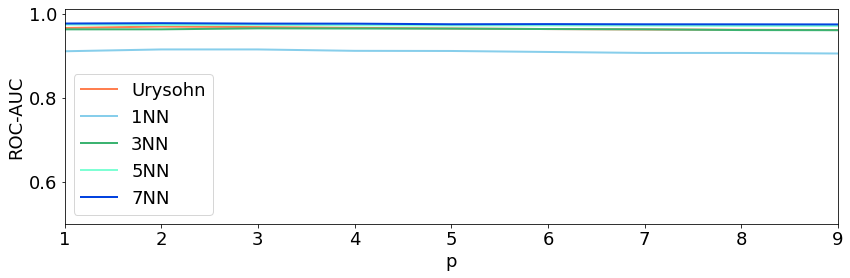

In [3]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))

# Plot the second array as a horizontal line with a different fancy color
ax.plot(p_metric, ury_auc_tests, label='Urysohn', color='coral', linestyle='-', linewidth=2)
# Plot the first array as a horizontal line with a fancy color
ax.plot(p_metric, one_knn_auc_tests, label='1NN', color='skyblue', linestyle='-', linewidth=2)
# Plot the first array as a horizontal line with a fancy color
ax.plot(p_metric, three_knn_auc_tests, label='3NN', color='mediumseagreen', linestyle='-', linewidth=2)
# Plot the first array as a horizontal line with a fancy color
ax.plot(p_metric, five_knn_auc_tests, label='5NN', color='aquamarine', linestyle='-', linewidth=2)
# Plot the first array as a horizontal line with a fancy color
ax.plot(p_metric, seven_knn_auc_tests, label='7NN', color='xkcd:blue', linestyle='-', linewidth=2)

# Add labels, legend, and title
ax.set_xlabel('p', fontsize=18)
ax.set_ylabel('ROC-AUC', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(fontsize=18)

# Show the plot
plt.tight_layout()
plt.xlim(min(p_metric),max(p_metric))
plt.ylim(0.5,1.01)
# plt.grid(axis='x', linestyle='--', alpha=0.6)
fig.savefig(config.FIGS/'Fig_23.pdf', dpi=700,bbox_inches='tight')
plt.show()

## Sensitivity to data clustering

In [4]:
# Generate synthetic dataset
n_samples, n_features =10000, 15
X, y = make_classification(n_samples=n_samples,
                           n_features=n_features,
                           n_informative=int(n_features * 0.6),
                           n_redundant=int(n_features * 0.2),
                           n_classes=2,
                           random_state=config.SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=config.SEED)

# Initialize variables to store results
ratios = np.linspace(0.1, 1.0, 20)  # Clustering ratios from 10% to 100%
ury_auc_tests = []
one_knn_auc_tests, three_knn_auc_tests, five_knn_auc_tests, seven_knn_auc_tests = [], [], [], []

for ratio in ratios:
    # Simulate clustering by reducing the size of the training set
    cluster_size = int(len(X_train) * ratio)
    X_train_clustered = X_train[:cluster_size]
    y_train_clustered = y_train[:cluster_size]
    
    # Train Urysohn classifier on the balanced dataset and compute AUC with the test sample
    ury = UrysohnClassifier(p=1, threshold=0.5, n_jobs=-1)
    ury.fit(X_train_clustered, y_train_clustered)
    y_probs_tests = ury.predict_proba(X_test)[:, 1]
    ury_auc_tests.append(roc_auc_score(y_test, y_probs_tests))    
    
    # Fits the 1NN model
    knn = KNeighborsClassifier(n_neighbors=1, p=1, n_jobs=-1)
    knn.fit(X_train_clustered, y_train_clustered)
    y_probs_tests = knn.predict_proba(X_test)[:, 1]
    # Compute the AUC score for the test sets with 1NN
    one_knn_auc_tests.append(roc_auc_score(y_test, y_probs_tests))
    
    # Fits the 3NN model
    knn = KNeighborsClassifier(n_neighbors=3, p=1, n_jobs=-1)
    knn.fit(X_train_clustered, y_train_clustered)
    y_probs_tests = knn.predict_proba(X_test)[:, 1]
    # Compute the AUC score for the test sets with 3NN
    three_knn_auc_tests.append(roc_auc_score(y_test, y_probs_tests))
    
    # Fits the 5NN model
    knn = KNeighborsClassifier(n_neighbors=5, p=1, n_jobs=-1)
    knn.fit(X_train_clustered, y_train_clustered)
    y_probs_tests = knn.predict_proba(X_test)[:, 1]
    # Compute the AUC score for the test sets with 5NN
    five_knn_auc_tests.append(roc_auc_score(y_test, y_probs_tests))
    
    # Fits the 7NN model
    knn = KNeighborsClassifier(n_neighbors=7, p=1, n_jobs=-1)
    knn.fit(X_train_clustered, y_train_clustered)
    y_probs_tests = knn.predict_proba(X_test)[:, 1]
    # Compute the AUC score for the test sets with 7NN
    seven_knn_auc_tests.append(roc_auc_score(y_test, y_probs_tests))   

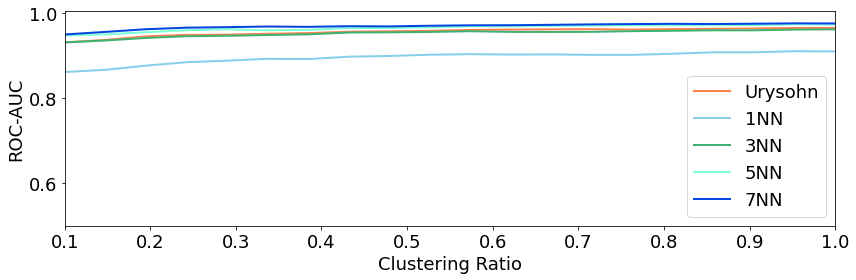

In [5]:
# Plot the results
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))
# Plot the second array as a horizontal line with a different fancy color
ax.plot(ratios, ury_auc_tests, label='Urysohn', color='coral', linestyle='-', linewidth=2)
# Plot the first array as a horizontal line with a fancy color
ax.plot(ratios, one_knn_auc_tests, label='1NN', color='skyblue', linestyle='-', linewidth=2)
# Plot the first array as a horizontal line with a fancy color
ax.plot(ratios, three_knn_auc_tests, label='3NN', color='mediumseagreen', linestyle='-', linewidth=2)
# Plot the first array as a horizontal line with a fancy color
ax.plot(ratios, five_knn_auc_tests, label='5NN', color='aquamarine', linestyle='-', linewidth=2)
# Plot the first array as a horizontal line with a fancy color
ax.plot(ratios, seven_knn_auc_tests, label='7NN', color='xkcd:blue', linestyle='-', linewidth=2)
plt.xlabel('Clustering Ratio', fontsize=18)
plt.ylabel('ROC-AUC', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.legend(loc='lower right', fontsize=18)
plt.xlim(0.1,1)
plt.ylim(0.5,1.005)
plt.tight_layout()
fig.savefig(config.FIGS/'Fig_24.pdf', dpi=700,bbox_inches='tight')
plt.show()

## Sensitivity to class imbalance

In [6]:
# Generate synthetic dataset
n_samples, n_features =10000, 15
X, y = make_classification(n_samples=n_samples,
                           n_features=n_features,
                           n_informative=int(n_features * 0.6),
                           n_redundant=int(n_features * 0.2),
                           n_classes=2,
                           random_state=config.SEED)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=config.SEED)

# Define a range of imbalance ratios (from 10% to 90% minority class)
imbalance_ratios = np.linspace(0.001, 0.999, 100)

ury_auc_tests = []
one_knn_auc_tests, three_knn_auc_tests, five_knn_auc_tests, seven_knn_auc_tests = [], [], [], []

# Loop through different imbalance ratios
for imbalance_ratio in imbalance_ratios:
    # Create an imbalanced dataset by randomly undersampling the majority class
    minority_class_indices = np.where(y_train == 1)[0]
    majority_class_indices = np.where(y_train == 0)[0]
    num_minority_samples = int(len(minority_class_indices) * (1 - imbalance_ratio))
    random_majority_indices = np.random.choice(majority_class_indices, num_minority_samples, replace=True)
    balanced_indices = np.concatenate((minority_class_indices, random_majority_indices))
    
    # Convert to NumPy arrays for indexing
    X_train_balanced = X_train[balanced_indices]
    y_train_balanced = y_train[balanced_indices]

    # Train Urysohn classifier on the balanced dataset and compute AUC with the test sample
    ury = UrysohnClassifier(p=1, threshold=0.5, n_jobs=-1)
    ury.fit(X_train_balanced, y_train_balanced)
    y_probs_tests = ury.predict_proba(X_test)[:, 1]
    ury_auc_tests.append(roc_auc_score(y_test, y_probs_tests))    
    
    # Fits the 1NN model
    knn = KNeighborsClassifier(n_neighbors=1, p=1, n_jobs=-1)
    knn.fit(X_train_balanced, y_train_balanced)
    y_probs_tests = knn.predict_proba(X_test)[:, 1]
    # Compute the AUC score for the test sets with 1NN
    one_knn_auc_tests.append(roc_auc_score(y_test, y_probs_tests))
    
    # Fits the 3NN model
    knn = KNeighborsClassifier(n_neighbors=3, p=1, n_jobs=-1)
    knn.fit(X_train_balanced, y_train_balanced)
    y_probs_tests = knn.predict_proba(X_test)[:, 1]
    # Compute the AUC score for the test sets with 3NN
    three_knn_auc_tests.append(roc_auc_score(y_test, y_probs_tests))
    
    # Fits the 5NN model
    knn = KNeighborsClassifier(n_neighbors=5, p=1, n_jobs=-1)
    knn.fit(X_train_balanced, y_train_balanced)
    y_probs_tests = knn.predict_proba(X_test)[:, 1]
    # Compute the AUC score for the test sets with 5NN
    five_knn_auc_tests.append(roc_auc_score(y_test, y_probs_tests))
    
    # Fits the 7NN model
    knn = KNeighborsClassifier(n_neighbors=7, p=1, n_jobs=-1)
    knn.fit(X_train_balanced, y_train_balanced)
    y_probs_tests = knn.predict_proba(X_test)[:, 1]
    # Compute the AUC score for the test sets with 7NN
    seven_knn_auc_tests.append(roc_auc_score(y_test, y_probs_tests))   
    

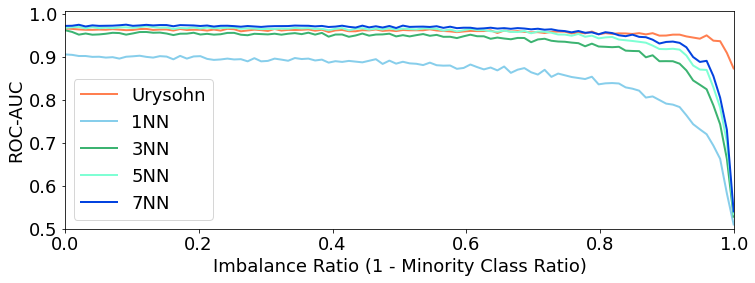

In [7]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 4))
# Plot the sensitivity of KNN and Ury to class imbalance

# Plot the second array as a horizontal line with a different fancy color
ax.plot(imbalance_ratios, ury_auc_tests, label='Urysohn', color='coral', linestyle='-', linewidth=2)
# Plot the first array as a horizontal line with a fancy color
ax.plot(imbalance_ratios, one_knn_auc_tests, label='1NN', color='skyblue', linestyle='-', linewidth=2)
# Plot the first array as a horizontal line with a fancy color
ax.plot(imbalance_ratios, three_knn_auc_tests, label='3NN', color='mediumseagreen', linestyle='-', linewidth=2)
# Plot the first array as a horizontal line with a fancy color
ax.plot(imbalance_ratios, five_knn_auc_tests, label='5NN', color='aquamarine', linestyle='-', linewidth=2)
# Plot the first array as a horizontal line with a fancy color
ax.plot(imbalance_ratios, seven_knn_auc_tests, label='7NN', color='xkcd:blue', linestyle='-', linewidth=2)
plt.xlabel('Imbalance Ratio (1 - Minority Class Ratio)', fontsize=18)
plt.ylabel('ROC-AUC', fontsize=18)
plt.xlim(0,1)
plt.ylim(0.5,1.005)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.legend(loc='lower left',fontsize=18)
fig.savefig(config.FIGS/'Fig_25.pdf', dpi=700,bbox_inches='tight')
plt.show()

## Variable Importance

In [2]:
# Generate synthetic dataset
n_samples, n_features =10000, 9
var_names = ['Feature[{}]'.format(el) for el in range(n_features)]
X, y = make_classification(n_samples=n_samples,
                           n_features=n_features,
                           n_informative=int(n_features * 0.6),
                           n_redundant=int(n_features * 0.2),
                           n_classes=2,
                           random_state=config.SEED)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=config.SEED)

In [3]:
# Trains model
ury = UrysohnClassifier(p = 1, threshold =0.5, n_jobs=-1)
ury.fit(X_train,y_train)

UrysohnClassifier(n_jobs=-1, p=1)

#### IMPACT EXPLAINS

In [4]:
impact_scores = ury.impact_explains(X_test, col_names=var_names, normalize=True, include_average=True, n_jobs=-1)

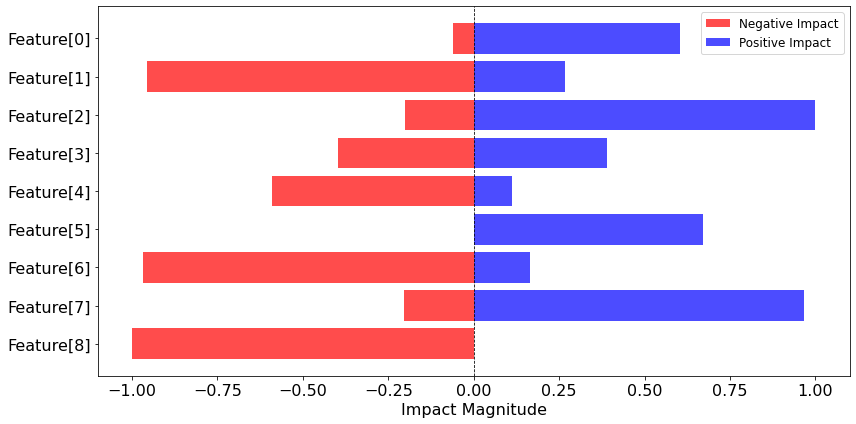

In [5]:
df = impact_scores.sort_index(ascending=True)

# Sort index by variable number instead of alphabetically
df.index = pd.CategoricalIndex(df.index, categories=var_names, ordered=True)
df = df.sort_index()

fig, ax = plt.subplots(figsize=(12, 6))
y_pos = np.arange(len(df))

# Plot Negative Impact (red bars to left)
ax.barh(y_pos, -df['Negative Impact'], color='red', label='Negative Impact', alpha=0.7)

# Plot Positive Impact (blue bars to right)
ax.barh(y_pos, df['Positive Impact'], color='blue', label='Positive Impact', alpha=0.7)

ax.set_yticks(y_pos)
ax.set_yticklabels(df.index, fontsize=16)
plt.xticks(fontsize=16)
ax.invert_yaxis()
ax.axvline(x=0, color='black', linewidth=0.8, linestyle='--')
ax.set_xlabel('Impact Magnitude', fontsize=16)
ax.legend(loc='best', fontsize=12)
plt.tight_layout()
plt.show()

fig.savefig(config.FIGS / 'Fig_26.pdf', dpi=700, bbox_inches='tight')

#### PERMUTATION FEATURE IMPORTANCE

In [6]:
pfi = ury.pfi_explains(X_test, y_test, col_names=var_names, n_repeats=30, normalize=True, 
                       correlation_threshold=0.4, n_jobs=-1)

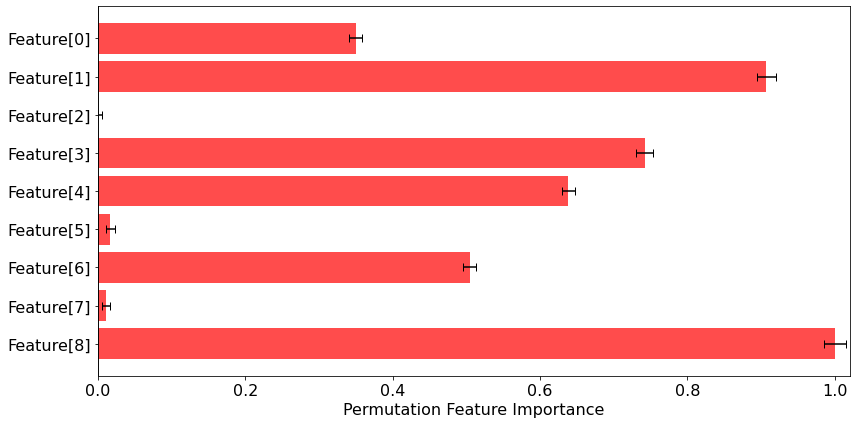

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

# Plot with error bars
ax.barh(pfi.index, pfi['PFI_Mean'], xerr=pfi['PFI_StdErr'], color='red', alpha=0.7, ecolor='black', capsize=4)

# Axis settings
ax.set_yticks(range(len(pfi.index)))
ax.set_yticklabels(pfi.index, fontsize=16)
ax.invert_yaxis()  # So top feature is at top
ax.axvline(x=0, color='black', linewidth=0.8)
ax.set_xlabel('Permutation Feature Importance', fontsize=16)
plt.xlim(0,1.02)
plt.xticks(fontsize=16)
plt.tight_layout()
plt.show()

fig.savefig(config.FIGS / 'Fig_27.pdf', dpi=700, bbox_inches='tight')

In [10]:
from scipy.stats import spearmanr

impacts = ['Negative Impact', 'Positive Impact', 'Average Impact']

for el in impacts:
    # Extract impact from impact_scores
    impact_importance = impact_scores[el].copy()
    
    # Match index (feature names) across both
    common_features = impact_importance.index.intersection(pfi.index)
    impact_importance = impact_importance.loc[common_features]
    pfi_importance = pfi.loc[common_features]["PFI_Mean"]
    
    # Compute Spearman correlation
    corr, pval = spearmanr(impact_importance.rank(), pfi_importance.rank())
    print(f"Spearman correlation between {el:} and PFI ranks: {corr:.3f} (p={pval:.3g})")


Spearman correlation between Negative Impact and PFI ranks: 0.750 (p=0.0199)
Spearman correlation between Positive Impact and PFI ranks: -0.867 (p=0.0025)
Spearman correlation between Average Impact and PFI ranks: 0.000 (p=1)


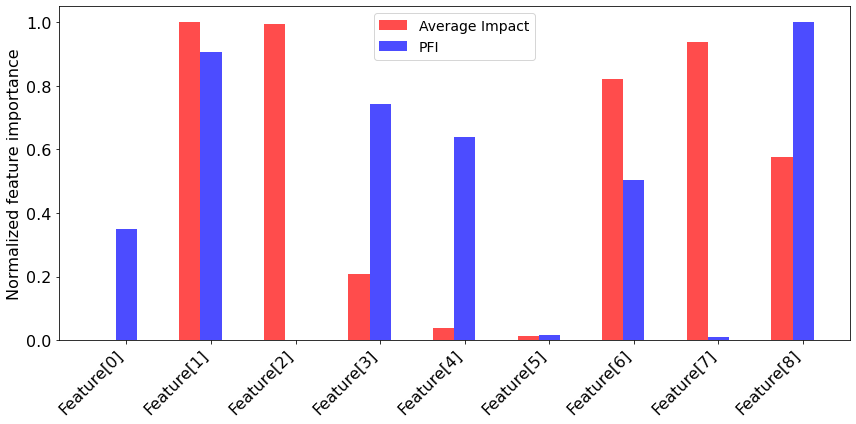

In [9]:
# Extract impact from impact_scores
impact_importance = impact_scores['Average Impact'].copy()

plt.figure(figsize=(12, 6))
bar_width = 0.25
index = np.arange(len(impact_importance))

plt.bar(index, impact_importance, bar_width, label='Average Impact', color='red', alpha=0.7)
plt.bar(index + bar_width, pfi_importance, bar_width, label='PFI', color='blue', alpha=0.7)
plt.xticks(index + bar_width, pfi_importance.index, rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel("Normalized feature importance", fontsize=16)
plt.legend(fontsize=14, loc='best')
plt.tight_layout()
plt.savefig(config.FIGS / 'Fig_28.pdf', dpi=700, bbox_inches='tight')
plt.show()

In [10]:
# Experiment setup
n_features_list = range(5, 51)

# Store correlation results
results = []

for n_features in n_features_list:
    print(f"\nRunning for n_features = {n_features}")

    # Generate data
    n_samples = 10000
    var_names = [f"Variable[{i}]" for i in range(n_features)]
    X, y = make_classification(n_samples=n_samples,n_features=n_features,
                               n_informative=int(n_features * 0.6), n_redundant=int(n_features * 0.2),
                               n_classes=2, random_state=config.SEED)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, 
                                                        random_state=config.SEED)

    ury = UrysohnClassifier(p=1, threshold=0.5,n_jobs=-1)
    ury.fit(X_train, y_train)
    
    # Explainability methods
    impact_scores = ury.impact_explains(X_test, col_names=var_names, normalize=True, 
                                        include_average=True, n_jobs=-1)
    pos_impact_vals = impact_scores['Positive Impact'].values
    neg_impact_vals = impact_scores['Negative Impact'].values
    avg_impact_vals = impact_scores['Average Impact'].values
    
    pfi = ury.pfi_explains(X_test, y_test, col_names=var_names, n_repeats=10, 
                           normalize=True, correlation_threshold=0.5, n_jobs=-1)
    
    pfi = pfi.reindex(impact_scores.index)
    pfi_vals = pfi["PFI_Mean"]
    
    # Compute correlation between methods
    pos_corr, pos_pval = spearmanr(pos_impact_vals, pfi_vals, nan_policy='omit')
    neg_corr, neg_pval = spearmanr(neg_impact_vals, pfi_vals, nan_policy='omit')
    avg_corr, avg_pval = spearmanr(avg_impact_vals, pfi_vals, nan_policy='omit')
#         corr, pval = spearmanr(impact_vals.rank(), pfi_vals.rank(), nan_policy='omit')
    results.append({"n_features": n_features, "pos_correlation": pos_corr,"pos_pval": pos_pval,
                    "neg_correlation": neg_corr,"neg_pval": neg_pval,
                    "avg_correlation": avg_corr,"avg_pval": avg_pval})

# Store all results
results_df = pd.DataFrame(results)


Running for n_features = 5

Running for n_features = 6

Running for n_features = 7

Running for n_features = 8

Running for n_features = 9

Running for n_features = 10

Running for n_features = 11

Running for n_features = 12

Running for n_features = 13

Running for n_features = 14

Running for n_features = 15

Running for n_features = 16

Running for n_features = 17

Running for n_features = 18

Running for n_features = 19

Running for n_features = 20

Running for n_features = 21

Running for n_features = 22

Running for n_features = 23

Running for n_features = 24

Running for n_features = 25

Running for n_features = 26

Running for n_features = 27

Running for n_features = 28

Running for n_features = 29

Running for n_features = 30

Running for n_features = 31

Running for n_features = 32

Running for n_features = 33

Running for n_features = 34

Running for n_features = 35

Running for n_features = 36

Running for n_features = 37

Running for n_features = 38

Running for n_feat

In [11]:
# Store all results
results_df = pd.DataFrame(results)
results_df

,n_features,pos_correlation,pos_pval,neg_correlation,neg_pval,avg_correlation,avg_pval
0,5,-0.300000,6.238377e-01,0.300000,6.238377e-01,-0.500000,0.391002
1,6,-0.428571,3.965015e-01,0.485714,3.287230e-01,-0.028571,0.957155
2,7,-0.857143,1.369733e-02,0.892857,6.807187e-03,0.035714,0.939408
3,8,-0.833333,1.017554e-02,0.666667,7.098765e-02,-0.071429,0.866526
4,9,-0.866667,2.495398e-03,0.750000,1.994213e-02,0.000000,1.000000
5,10,-0.466667,1.739386e-01,0.709091,2.166592e-02,0.587879,0.073878
6,11,-0.290909,3.854570e-01,0.827273,1.676974e-03,0.318182,0.340298
7,12,-0.671329,1.683146e-02,0.636364,2.609689e-02,-0.104895,0.745609
8,13,-0.736264,4.107709e-03,0.692308,8.730318e-03,0.142857,0.641516
9,14,-0.525275,5.374750e-02,0.274725,3.418297e-01,-0.362637,0.202565


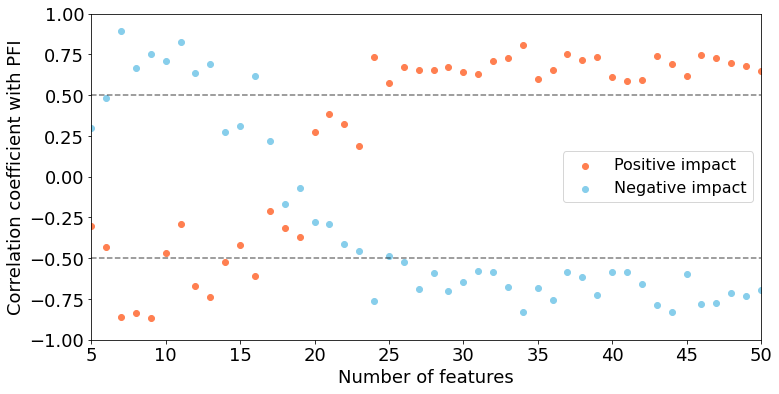

In [12]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))
# Plot the sensitivity of KNN and Ury to class imbalance

# Plot the second array as a horizontal line with a different fancy color
ax.scatter(results_df['n_features'].values,results_df['pos_correlation'].values, 
        label='Positive impact', color='coral')
ax.scatter(results_df['n_features'].values,results_df['neg_correlation'].values, 
        label='Negative impact', color='skyblue')
ax.plot(results_df['n_features'].values,0.5*np.ones(len(results_df['n_features'].values)), 
        color='k',linestyle='dashed',alpha=0.5)
ax.plot(results_df['n_features'].values,-0.5*np.ones(len(results_df['n_features'].values)), 
        color='k',linestyle='dashed',alpha=0.5)
# ax.scatter(results_df['n_features'].values,results_df['avg_correlation'].values, 
#         label='Average impact', color='green', alpha=0.5)
plt.xlabel('Number of features', fontsize=18)
plt.ylabel('Correlation coefficient with PFI', fontsize=18)
plt.xlim(min(results_df['n_features'].values),max(results_df['n_features'].values))
plt.ylim(-1.,1.)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.legend(loc='best',fontsize=16)
fig.savefig(config.FIGS/'Fig_29.pdf', dpi=700,bbox_inches='tight')
plt.show()

In [13]:
results_df.to_csv('correlations_pfi_impact.csv')